<a href="https://colab.research.google.com/github/Kamalgar/collab/blob/master/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [2]:
# Libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import time
import datetime
import random
import warnings
warnings.filterwarnings('ignore')

# Tokenize to add stopwords
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

# Data loading utility
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split

# Models
from torch import nn

from transformers import BertModel, BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from transformers import logging
logging.set_verbosity_error()

# Training
from torch import optim

# Evaluation
from sklearn.metrics import accuracy_score, matthews_corrcoef

%matplotlib inline

# specify GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
import pandas as pd
import yfinance as yf
import datetime

# Downloading FTSE100 stocks data
ftse100_stocks = yf.download("SBIN.NS JIOFIN.NS AXS ADANIPORTS.NS  PANW", start=datetime.datetime(2019, 1, 1),
                             end=datetime.datetime(2024,3,12), group_by='tickers')

# Save DataFrame to a pickle file
ftse100_stocks.to_pickle('aqr_stocks.pkl')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


In [4]:
article_sentiments = pd.read_pickle('aqr_stocks.pkl')
article_sentiments

Ticker       JIOFIN.NS                                                   \
Price             Open        High         Low       Close       Volume   
Date                                                                      
2019-01-01         NaN         NaN         NaN         NaN          NaN   
2019-01-02         NaN         NaN         NaN         NaN          NaN   
2019-01-03         NaN         NaN         NaN         NaN          NaN   
2019-01-04         NaN         NaN         NaN         NaN          NaN   
2019-01-07         NaN         NaN         NaN         NaN          NaN   
...                ...         ...         ...         ...          ...   
2024-03-05  324.000000  327.899994  319.500000  321.700012   18301430.0   
2024-03-06  322.950012  333.899994  321.350006  326.350006   53717380.0   
2024-03-07  329.000000  337.399994  324.200012  333.899994   35988720.0   
2024-03-08         NaN         NaN         NaN         NaN          NaN   
2024-03-11  336.899994  359.850006  332.450012  355.649994  121739300.0   

Ticker            AXS                                              ...  \
Price            Open       High        Low      Close     Volume  ...   
Date                                                               ...   
2019-01-01        NaN        NaN        NaN        NaN        NaN  ...   
2019-01-02  42.692837  43.120102  42.433130  42.784992   968700.0  ...   
2019-01-03  42.542029  43.136849  42.525273  42.684452   844500.0  ...   
2019-01-04  43.170356  44.753744  43.069825  44.669968  1003200.0  ...   
2019-01-07  44.401890  44.879419  44.158935  44.217579   635500.0  ...   
...               ...        ...        ...        ...        ...  ...   
2024-03-05  58.968689  59.654031  58.968689  59.438637   570200.0  ...   
2024-03-06  59.693195  60.075027  58.802252  59.409267   669600.0  ...   
2024-03-07  59.409269  59.898798  59.252619  59.663822   435500.0  ...   
2024-03-08  59.644243  60.319795  59.526757  59.898800   432300.0  ...   
2024-03-11  59.751939  60.427492  59.751939  60.192516   520700.0  ...   

Ticker         SBIN.NS                                                  \
Price             Open        High         Low       Close      Volume   
Date                                                                     
2019-01-01  280.020147  283.032139  276.584611  281.996765  11837127.0   
2019-01-02  281.526196  284.726421  275.878730  276.631714  25559853.0   
2019-01-03  277.667094  278.184767  273.055002  273.996246  17548347.0   
2019-01-04  274.937482  281.432063  274.372730  280.161377  19514041.0   
2019-01-07  283.361597  283.785168  277.855340  278.890686  14579399.0   
...                ...         ...         ...         ...         ...   
2024-03-05  756.808577  773.970784  756.415150  771.020264  18088847.0   
2024-03-06  770.725193  777.265477  760.152494  770.971069  26710525.0   
2024-03-07  776.970463  780.314410  770.085914  775.052612  15497868.0   
2024-03-08         NaN         NaN         NaN         NaN         NaN   
2024-03-11  776.970482  779.724290  757.841260  760.939331  16778340.0   

Ticker     ADANIPORTS.NS                                                    
Price               Open         High          Low        Close     Volume  
Date                                                                        
2019-01-01    372.497685   376.933335   370.328076   375.101227  1233249.0  
2019-01-02    374.136955   375.053023   364.494250   367.676331  1506543.0  
2019-01-03    368.737019   371.533397   363.144262   364.590668  1902063.0  
2019-01-04    365.120995   370.231646   362.421049   368.495941  1669709.0  
2019-01-07    371.244136   373.124476   365.796014   368.013824  1260331.0  
...                  ...          ...          ...          ...        ...  
2024-03-05   1338.308077  1349.161413  1328.300963  1332.582642  1815438.0  
2024-03-06   1336.963689  1338.855597  1298.429072  1319.140259  2758443.0  
2024-03-07   1324.118867  13

In [5]:
article_sentiments.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1347 entries, 2019-01-01 to 2024-03-11
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   (JIOFIN.NS, Open)        136 non-null    float64
 1   (JIOFIN.NS, High)        136 non-null    float64
 2   (JIOFIN.NS, Low)         136 non-null    float64
 3   (JIOFIN.NS, Close)       136 non-null    float64
 4   (JIOFIN.NS, Volume)      136 non-null    float64
 5   (AXS, Open)              1306 non-null   float64
 6   (AXS, High)              1306 non-null   float64
 7   (AXS, Low)               1306 non-null   float64
 8   (AXS, Close)             1306 non-null   float64
 9   (AXS, Volume)            1306 non-null   float64
 10  (PANW, Open)             1306 non-null   float64
 11  (PANW, High)             1306 non-null   float64
 12  (PANW, Low)              1306 non-null   float64
 13  (PANW, Close)            1306 non-null   float64
 14  (PANW,

In [6]:
!pip install pandas
import pandas as pd
article_sentiments = pd.DataFrame({'Label': [0, 1, 0, 1, 1]})

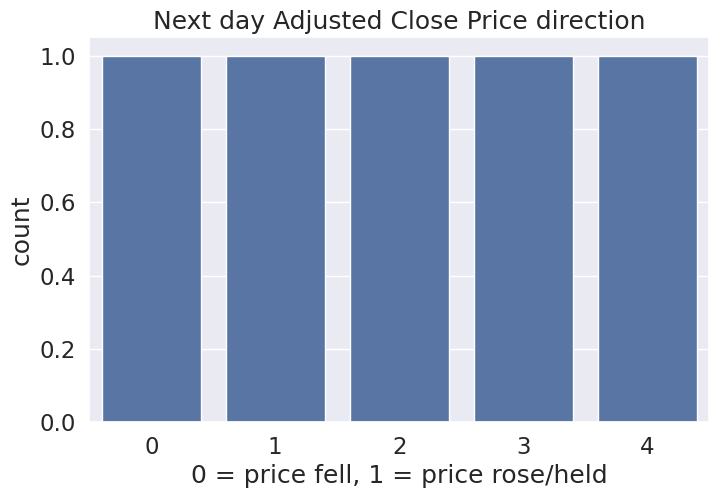

In [7]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (8,5)
sns.countplot(article_sentiments.Label)
plt.title('Next day Adjusted Close Price direction')
plt.xlabel('0 = price fell, 1 = price rose/held');

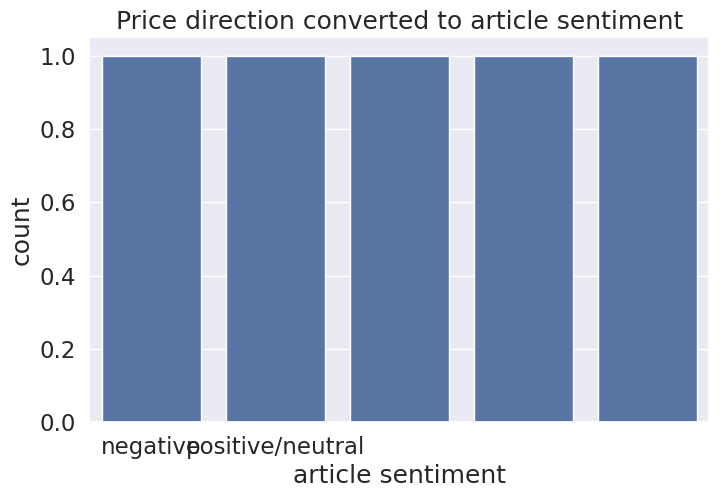

In [8]:
# Plot showing Adjusted Close prices converted to sentiment

def to_sentiment(label):
  label = int(label)
  if label == 0:
    return 0
  else:
    return 1

article_sentiments['sentiment'] = article_sentiments.Label.apply(to_sentiment)

class_names = ['negative', 'positive/neutral']

# Plot the counts of observations in each categorical bin
ax = sns.countplot(article_sentiments.sentiment)

# Label the plot
plt.title('Price direction converted to article sentiment')
plt.xlabel('article sentiment')
ax.set_xticklabels(class_names);

In [9]:
pip install nltk Googlenews newspaper3k wordcloud

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 40.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 23.2 MB/s eta 0:00:00
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13539 sha256=ffeefa15b66d573abd035909cd434bf248a73cf75ae243938b8d7d631458918c
  Stored in directory: /root/.cache/pip/wheels/fc/ab/f8/cce3a9ae6d828bd346be695f7ff54612cd22b7cbd7208d68f3
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3342 sha256=705fa46a2325a55918716a6b0569284290d6aa76c45a9b4ef3c9ae4ffa1bfcf3
  Stored

In [13]:
pip install lxml[html_clean]

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from GoogleNews import GoogleNews
from newspaper import Article
from newspaper import Config
from wordcloud import WordCloud, STOPWORDS

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [15]:
now = dt.date.today()
now = now.strftime('%m-%d-%Y')
yesterday = dt.date.today() - dt.timedelta(days = 1)
yesterday = yesterday.strftime('%m-%d-%Y')

nltk.download('punkt')
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:78.0) Gecko/20100101 Firefox/78.0'
config = Config()
config.browser_user_agent = user_agent
config.request_timeout = 10


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
company_name = input("Please provide the name of the Company or a Ticker: ")
if company_name != '':
    print(f'Searching for and analyzing {company_name}, Please be patient, it might take a while...')
    googlenews = GoogleNews(start=yesterday,end=now)
    googlenews.search(company_name)
    result = googlenews.result()
    df = pd.DataFrame(result)
    print(df)


Please provide the name of the Company or a Ticker: reliance
Searching for and analyzing reliance, Please be patient, it might take a while...


                                               title                  media  \
0  Anant Ambani Appointed Executive Director At R...       BW Businessworld   
1  Reliance Industries Q4 FY25 net profit rises b...                    MSN   
2  Reliance Industries Board Appoints Anant Amban...       Outlook Business   
3  Innovation drives us forward and IP protects w...               Facebook   
4  Reliance enters world's top 25 as net worth ri...      Business Standard   
5  Africa Faces Trade Crossroads as New US Tariff...                Okay.ng   
6  Reliance Jio unifies its JioFiber and Jio AirF...               OnlyTech   
7  Reliance Industries names Anant Ambani as Exec...  The Financial Express   
8  Anant Ambani gets a new role at Reliance Indus...         Bollywood Life   
9  Anant Ambani appointed executive director of R...      Business Standard   

          date                   datetime  \
0   1 hour ago 2025-04-26 13:11:56.598029   
1   1 hour ago 2025-04-26 13:11:56.61681

In [17]:
try:
    list =[]
    for i in df.index:
        dict = {}
        article = Article(df['link'][i],config=config) #providing the link
        try:
          article.download()
          article.parse()
          article.nlp()
        except:
           pass
        dict['Date']=df['date'][i]
        dict['Media']=df['media'][i]
        dict['Title']=article.title
        dict['Article']=article.text
        dict['Summary']=article.summary
        dict['Key_words']=article.keywords
        list.append(dict)
    check_empty = not any(list)
    # print(check_empty)
    if check_empty == False:
      news_df=pd.DataFrame(list) #creating dataframe
      print(news_df)

except Exception as e:
    #exception handling
    print("exception occurred:" + str(e))
    print('Looks like, there is some error in retrieving the data, Please try again or try with a different ticker.' )


          Date                  Media  \
0   1 hour ago       BW Businessworld   
1   1 hour ago                    MSN   
2  3 hours ago       Outlook Business   
3  3 hours ago               Facebook   
4  3 hours ago      Business Standard   
5  3 hours ago                Okay.ng   
6  3 hours ago               OnlyTech   
7  3 hours ago  The Financial Express   
8  3 hours ago         Bollywood Life   
9  3 hours ago      Business Standard   

                                               Title  \
0  Business News: Latest Business Economy Breakin...   
1                                                MSN   
2  Reliance Industries Board Appoints Anant Amban...   
3                                  Log into Facebook   
4                                                      
5  Latest Nigerian News: Breaking Updates & Top S...   
6                                                      
7                                                      
8  Anant Ambani gets a new role at Reliance 

In [22]:
news_df

,Date,Media,Title,Article,Summary,Key_words
0,1 hour ago,BW Businessworld,Business News: Latest Business Economy Breakin...,- AI adoption in India remains in its early st...,,"[economy, remains, public, solutions, rely, la..."
1,1 hour ago,MSN,MSN,,,[msn]
2,3 hours ago,Outlook Business,Reliance Industries Board Appoints Anant Amban...,Prior Position\n\nAnant has also been the part...,,"[reliance, key, executivedirector, energy, ana..."
3,3 hours ago,Facebook,Log into Facebook,Notice\n\nYou must log in to continue.,,"[continue, facebook, log, noticeyou]"
4,3 hours ago,Business Standard,,,,[]
5,3 hours ago,Okay.ng,Latest Nigerian News: Breaking Updates & Top S...,Google has officially opened applications for ...,,"[applications, google, latest, nigerian, today..."
6,3 hours ago,OnlyTech,,,,[]
7,3 hours ago,The Financial Express,,,,[]
8,3 hours ago,Bollywood Life,Anant Ambani gets a new role at Reliance Indus...,Anant Ambai served as a non-executive director...,,"[reliance, anant, earn, director, hell, 2025, ..."
9,3 hours ago,Business Standard,,,,[]


Positive Sentiment: 2.00
Neutral Sentiment: 8.00
Negative Sentiment: 0.00


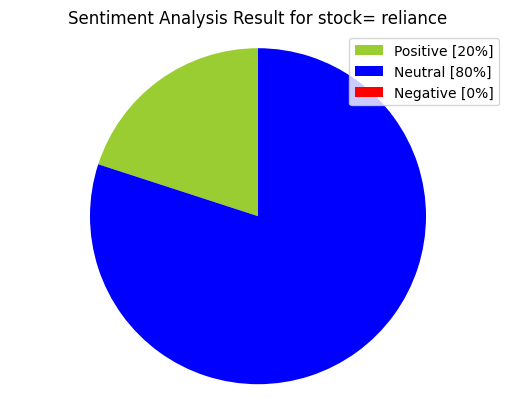

Wordcloud for reliance


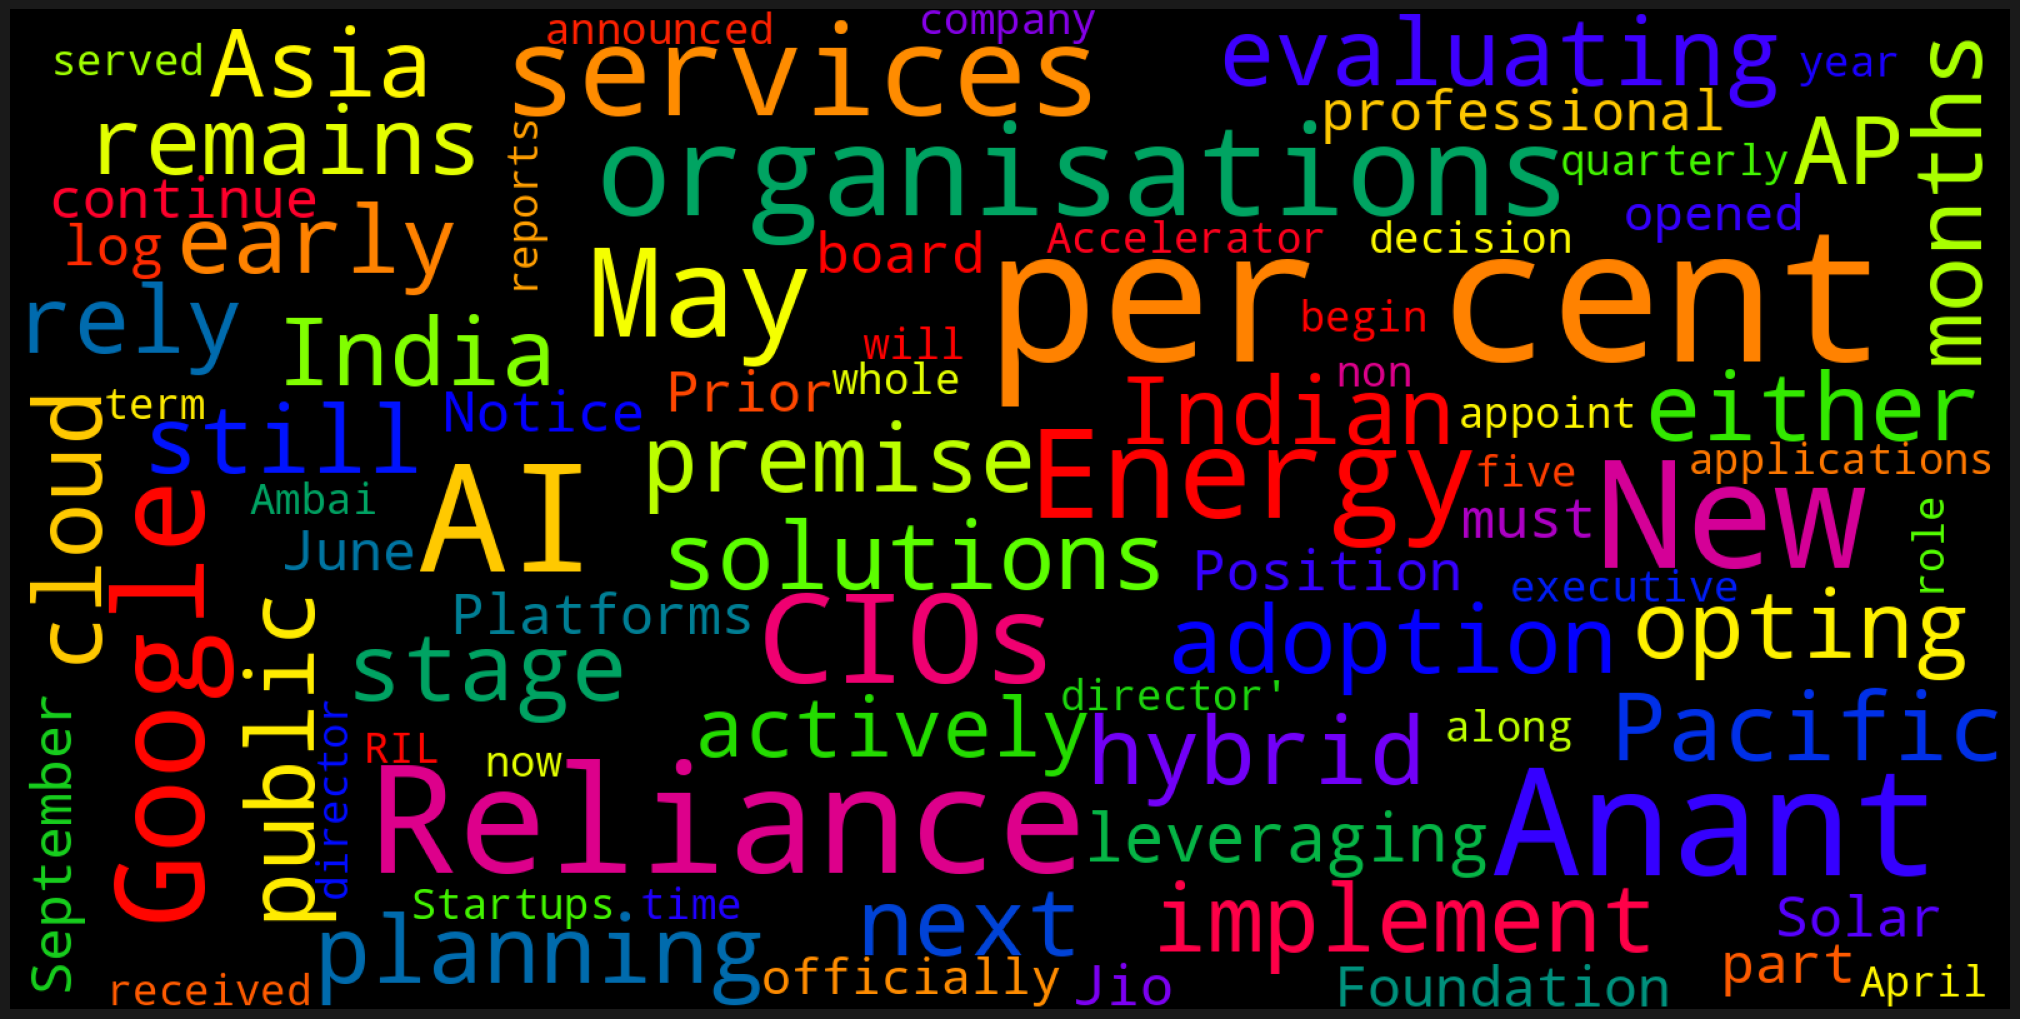

In [23]:

def percentage(part,whole):
    return 100 * float(part)/float(whole)


positive = 0
negative = 0
neutral = 0

news_list = []
neutral_list = []
negative_list = []
positive_list = []


for news in news_df['Article']:
    news_list.append(news)
    analyzer = SentimentIntensityAnalyzer().polarity_scores(news)
    neg = analyzer['neg']
    neu = analyzer['neu']
    pos = analyzer['pos']
    comp = analyzer['compound']

    if neg > pos:
        negative_list.append(news)
        negative += 1
    elif pos > neg:
        positive_list.append(news)
        positive += 1
    elif pos == neg:
        neutral_list.append(news)
        neutral += 1

positive = percentage(positive, len(news_df))
negative = percentage(negative, len(news_df))
neutral = percentage(neutral, len(news_df))


news_list = pd.DataFrame(news_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)

print("Positive Sentiment:", '%.2f' % len(positive_list), end='\n')
print("Neutral Sentiment:", '%.2f' % len(neutral_list), end='\n')
print("Negative Sentiment:", '%.2f' % len(negative_list), end='\n')

#Creating PieCart
labels = ['Positive ['+str(round(positive))+'%]' , 'Neutral ['+str(round(neutral))+'%]','Negative ['+str(round(negative))+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for stock= "+company_name+"" )
plt.axis('equal')
plt.show()

# Word cloud visualization
def word_cloud(text):
    stopwords = set(STOPWORDS)
    allWords = ' '.join([nws for nws in text])
    wordCloud = WordCloud(background_color='black',width = 1600, height = 800,stopwords = stopwords,min_font_size = 20,max_font_size=150,colormap='prism').generate(allWords)
    fig, ax = plt.subplots(figsize=(20,10), facecolor='k')
    plt.imshow(wordCloud)
    ax.axis("off")
    fig.tight_layout(pad=0)
    plt.show()

print('Wordcloud for ' + company_name)
word_cloud(news_df['Article'].values)
